In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
#!/bin/bash
!kaggle datasets download ashishpatel26/colorise-image


Dataset URL: https://www.kaggle.com/datasets/ashishpatel26/colorise-image
License(s): copyright-authors
 99% 116M/117M [00:07<00:00, 22.1MB/s]
100% 117M/117M [00:07<00:00, 16.8MB/s]


In [ ]:
import zipfile
import os

# Define the path to your downloaded zip file
zip_file_path = '/content/colorise-image.zip'  # Change this to the actual path of your zip file

# Define the destination folder for extraction
extraction_folder = '/content/drive/MyDrive/DATA/'  # Change this if you want to extract to a different folder

# Check if the destination folder exists, if not, create it
if not os.path.exists(extraction_folder):
    os.makedirs(extraction_folder)

# Extract the downloaded zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

print('Dataset extraction complete.')

Dataset extraction complete.


# Original Code and Paper

- Original code(caffe): https://github.com/richzhang/colorization/blob/master/colorization/demo/colorization_demo_v2.ipynb
- Paper: https://arxiv.org/pdf/1603.08511.pdf

In [ ]:
import cv2 # opencv 3.4.2+ required
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print(cv2.__version__)

4.11.0


# Prepare Model
- You need to download models from Zhang's server
- Run "get_models.sh" to get it

In [ ]:
proto = '/content/drive/MyDrive/DATA/colorization_deploy_v2.prototxt.txt'
weights = '/content/drive/MyDrive/DATA/colorization_release_v2_norebal.caffemodel'
# colorization_release_v2_norebal.caffemodel is trained with a classification loss with no class re-balancing term.
# The results are duller but "safer" colorizations
# weights = './models/colorization_release_v2_norebal.caffemodel'

# load cluster centers
pts_in_hull = np.load('/content/drive/MyDrive/DATA/pts_in_hull.npy')
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1).astype(np.float32)

# load model
net = cv2.dnn.readNetFromCaffe(proto, weights)
# net.getLayerNames()

# populate cluster centers as 1x1 convolution kernel
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull]
# scale layer doesn't look work in OpenCV dnn module, we need to fill 2.606 to conv8_313_rh layer manually
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full((1, 313), 2.606, np.float32)]

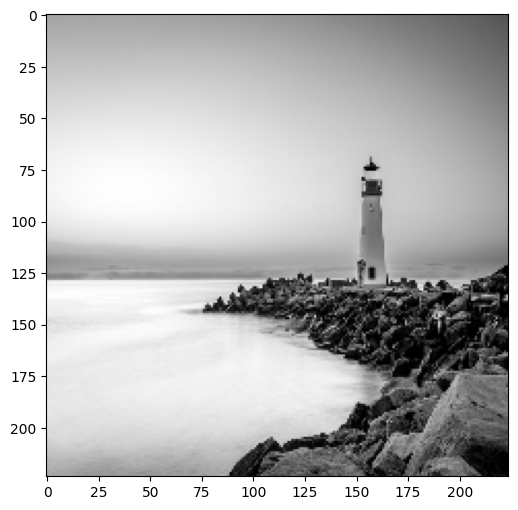

In [ ]:
img_path = '/content/drive/MyDrive/DATA/sample_17.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_input = img.copy()

# convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

img_rgb = img.copy()

# normalize input
img_rgb = (img_rgb / 255.).astype(np.float32)

# convert RGB to LAB
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
# only L channel to be used
img_l = img_lab[:, :, 0]

input_img = cv2.resize(img_l, (224, 224))
input_img -= 50 # subtract 50 for mean-centering

# plot images
# fig = plt.figure(figsize=(10, 5))
# fig.add_subplot(1, 2, 1)
# plt.imshow(img_rgb)
# fig.add_subplot(1, 2, 2)
# plt.axis('off')
plt.figure(figsize=(9,6))
plt.imshow(input_img, cmap='gray')

# Prediction

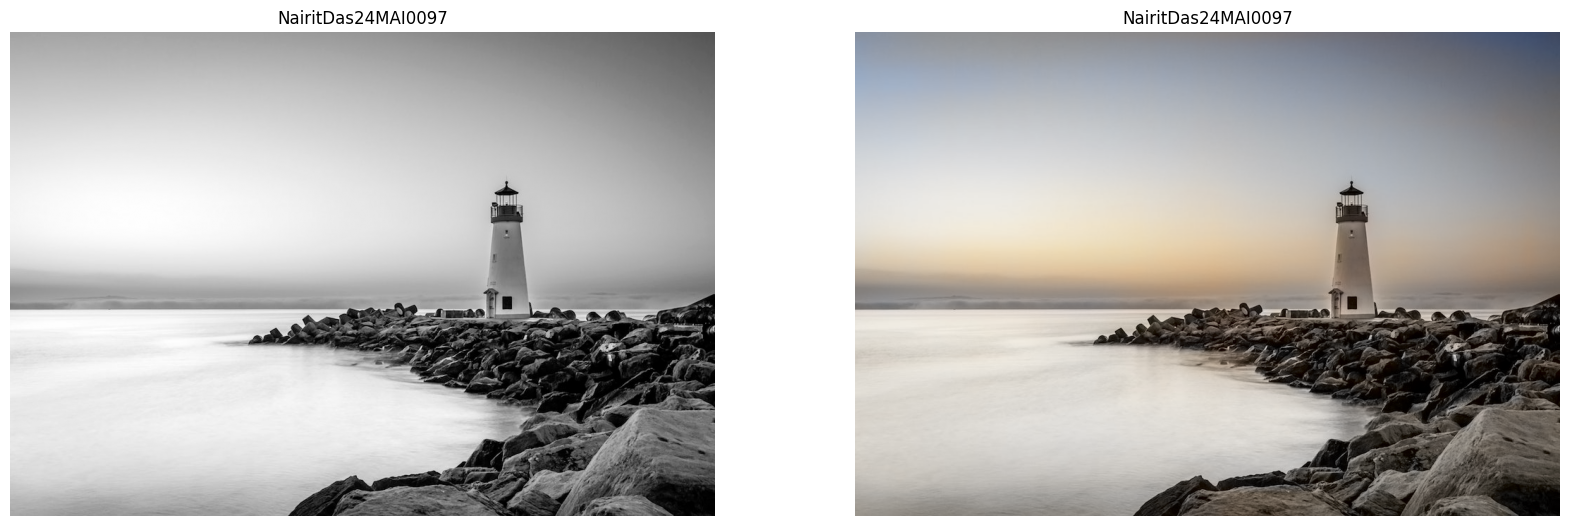

In [ ]:
net.setInput(cv2.dnn.blobFromImage(input_img))
pred = net.forward()[0,:,:,:].transpose((1, 2, 0))

# resize to original image shape
pred_resize = cv2.resize(pred, (img.shape[1], img.shape[0]))

# concatenate with original image L
pred_lab = np.concatenate([img_l[:, :, np.newaxis], pred_resize], axis=2)

# convert LAB to RGB
pred_rgb = cv2.cvtColor(pred_lab, cv2.COLOR_Lab2RGB)
pred_rgb = np.clip(pred_rgb, 0, 1) * 255
pred_rgb = pred_rgb.astype(np.uint8)

# plot prediction result
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1).axis('off')
plt.title("NairitDas24MAI0097")
plt.imshow(img_l, cmap='gray')
fig.add_subplot(1, 2, 2).axis('off')
plt.title("NairitDas24MAI0097")
plt.imshow(pred_rgb)
# plt.savefig(output_filename)

# save result image file
filename, ext = os.path.splitext(img_path)
# input_filename = '%s_input%s' % (filename, ext)
# output_filename = '%s_output%s' % (filename, ext)

# pred_rgb_output = cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR)

# cv2.imwrite(input_filename, img_input)
# cv2.imwrite(output_filename, np.concatenate([img, pred_rgb_output], axis=1))